In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
from sklearn import preprocessing
from sklearn.model_selection import *
from models import *

## **Exploratory Data Analysis**

In [2]:
data = pickle.load(open(r'../Data/deltaQ_cycles_v3.pkl', 'rb'))
#data2 = pickle.load(open(r'../Data/temp_features.pkl', 'rb'))

print(data['b1c1'].keys())

dict_keys(['cycle_life', 'DeltaQ_logVars', 'DeltaQ_mins', 'DeltaQ_means', 'DeltaT_max', 'DeltaT_logVars', 'DeltaIR'])


In [144]:
n_cycles = 98
cut_start = 1

features = [
    "DeltaQ_logVars",
    "DeltaQ_mins",
    # "DeltaQ_means",
    # "DeltaT_max",
    # "DeltaT_var",
]

n_cycles = n_cycles - cut_start
y = np.zeros(124)
x = np.zeros((124, n_cycles*len(features)))

for i, cell in enumerate(data.keys()):
    for j, feature in enumerate(features):
        x[i, j*n_cycles:(j+1)*n_cycles] = data[cell][feature][cut_start:]
    y[i] = np.log10(data[cell]["cycle_life"])

# convert to tensors and concatenate features and labels
x = torch.Tensor(x)
y = torch.Tensor(y)

## **AutoEncoder: Dimensionality Reduction**

### **Train Test Split**

In [145]:
test_ind = np.array([ 0,  2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32,
       34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66,
       68, 70, 72, 74, 76, 78, 80, 82, 83])

train_ind = np.array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33,
       35, 37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57, 59, 61, 63, 65, 67,
       69, 71, 73, 75, 77, 79, 81])

secondary_ind = np.array([ 84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,
        97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109,
       110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122,
       123])



Stage 1:

Epoch 80/800, loss: 336333.09
Epoch 160/800, loss: 5558.15
Epoch 240/800, loss: 17997.24
Epoch 320/800, loss: 11119.43
Epoch 400/800, loss: 15794.60
Epoch 480/800, loss: 11640.25
Epoch 560/800, loss: 33565.14
Epoch 640/800, loss: 11497.86
Epoch 720/800, loss: 9555.62
Epoch 800/800, loss: 36637.38
train 	 128.04024
test 	 121.16935
sec 	 333.71262


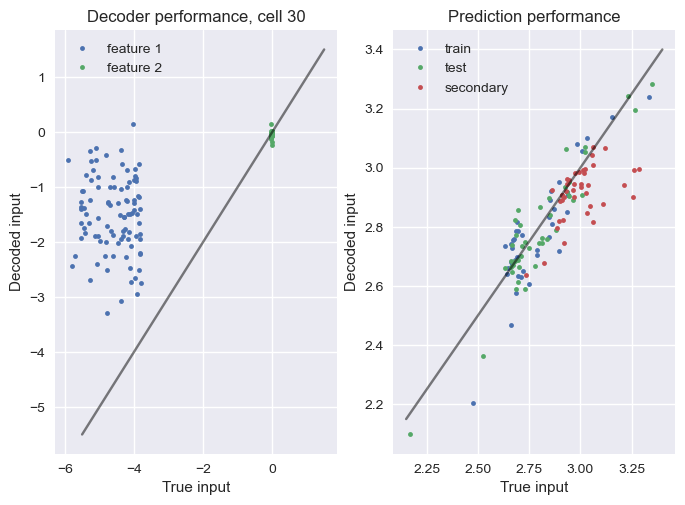


Stage 2:

Epoch 70/700, loss: 2.88
Epoch 140/700, loss: 2.71
Epoch 210/700, loss: 2.88
Epoch 280/700, loss: 2.05
Epoch 350/700, loss: 1.65
Epoch 420/700, loss: 1.66
Epoch 490/700, loss: 1.30
Epoch 560/700, loss: 1.47
Epoch 630/700, loss: 1.48
Epoch 700/700, loss: 1.53
train 	 78.39798
test 	 90.80413
sec 	 305.27307


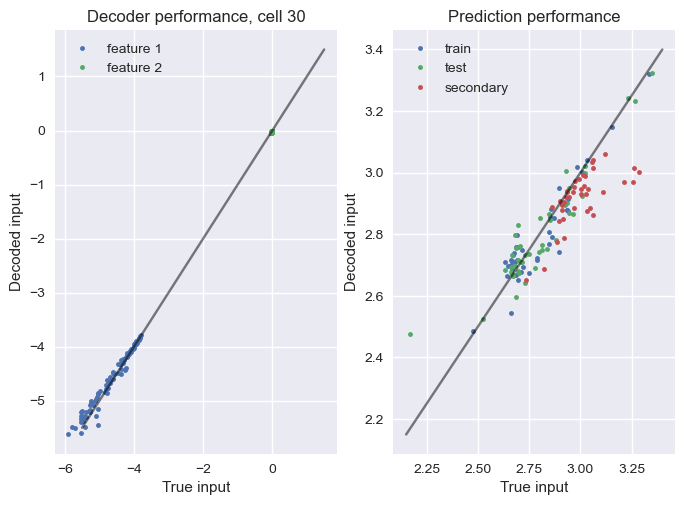

In [152]:
train_policy = {
    "num_stages": 2,
    "epochs": [800, 700],
    "learning_rates": [1e-5, 1e-4],
    "batch_sizes": [16, 16],
    "prediction_weights": [1, 0.0001],
    "decoding_weights": [10, 1],
    "en_weights": [1, 1]
}


model = AutoEncoder_ElasticNet(n_features=len(features), n_cycles=n_cycles)
#train = TensorDataset(torch.Tensor(x[train_ind]),torch.Tensor(y[train_ind]))
model.fit(x,y, train_policy)

In [153]:
model.encoder(x[5])

tensor([0.0000, 0.0000, 0.0000, 2.3896, 2.3974, 0.0000, 0.0000, 0.0000, 0.0000,
        4.0792, 1.0859, 4.3534, 0.0000, 0.0000, 3.9469, 0.0000, 0.0000, 2.5982,
        1.0864, 2.2244, 0.9175, 2.0177, 3.4990, 0.0000, 3.4541, 5.3365, 0.5640,
        0.0000, 2.8539, 0.0000, 2.1238, 0.0000], grad_fn=<ReluBackward0>)

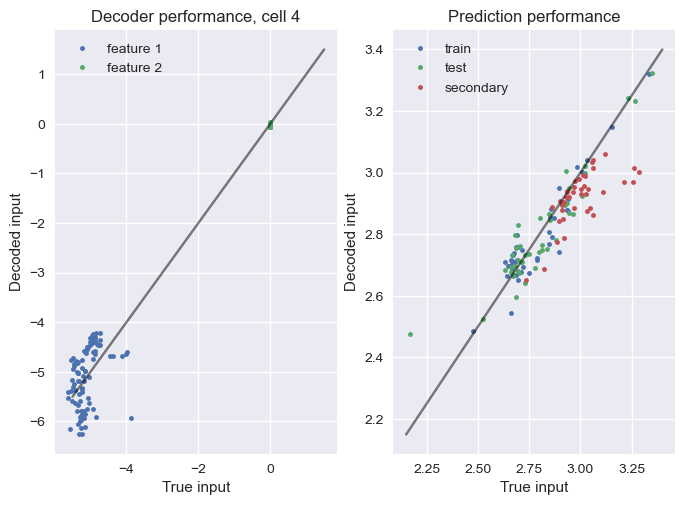

In [154]:
model.plotter(x, y, 4)

In [155]:
print(y[1], model.elastic_net_predict(x[1]))

tensor(3.3345) tensor([3.3212], grad_fn=<AddBackward0>)


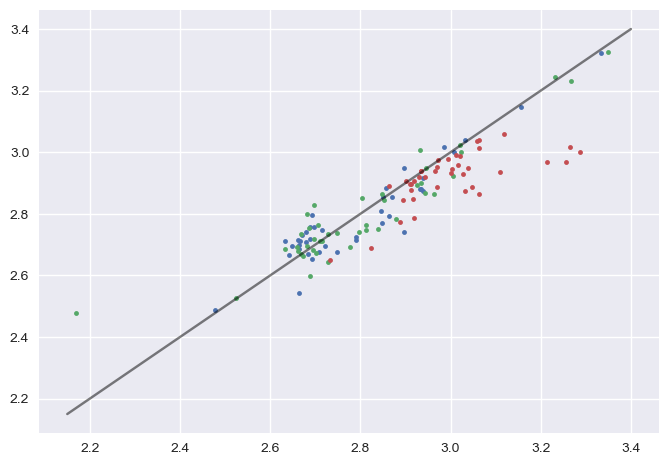

In [156]:
plt.plot(y[train_ind], model.elastic_net_predict(x[train_ind]).detach().numpy(), ".")
plt.plot(y[test_ind], model.elastic_net_predict(x[test_ind]).detach().numpy(), ".")
plt.plot(y[secondary_ind], model.elastic_net_predict(x[secondary_ind]).detach().numpy(), ".")
plt.plot(np.linspace(2.15, 3.4, 3), np.linspace(2.15, 3.4, 3), "k", alpha = 0.5)

# SVR

In [157]:
x_t = model.encoder(x[train_ind]).detach().numpy()
x_te = model.encoder(x[test_ind]).detach().numpy()
x_ste = model.encoder(x[secondary_ind]).detach().numpy()

print(x_t[0])

[0.         0.         0.         2.5545642  2.7217202  0.
 0.         0.         0.         4.330688   0.9589484  4.7413855
 0.         0.         4.121174   0.         0.         2.7374065
 1.1907262  2.2510571  0.90939754 2.305947   3.7069647  0.
 3.710073   5.765853   0.5074806  0.         3.1735384  0.
 2.2181706  0.        ]


In [158]:
scaler = preprocessing.StandardScaler().fit(list(x_t))
x_t = scaler.transform(list(x_t))
x_te = scaler.transform(list(x_te))
x_ste = scaler.transform(list(x_ste))

train = TensorDataset(torch.Tensor(x_t),torch.Tensor(y[train_ind]))
test = TensorDataset(torch.Tensor(x_te),torch.Tensor(y[test_ind]))
stest = TensorDataset(torch.Tensor(x_ste),torch.Tensor(y[secondary_ind]))

In [168]:
# parameters
lr = 0.0005
feat_dim = 2*16
d_model = 12
nepoch = 3000
batch_size = 1

In [169]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [170]:
# Load nodel, loss function, and optimizer
model = AttentionModel(feat_dim=feat_dim,d_model=d_model)
criterion = nn.MSELoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)


model.train()

# Training loop
for i in range(nepoch):
    total_loss_train = 0.0
    total_loss_test = 0.0
    total_loss_stest = 0.0

    train_batched = DataLoader(train,batch_size=batch_size,shuffle=True)
    test_batched = DataLoader(test,batch_size=1)
    stest_batched = DataLoader(stest,batch_size=1)

    for j,batch in enumerate(train_batched):
        optimizer.zero_grad()
        train_input, train_label = batch
        output = model(train_input.to(device))
        loss = criterion(10**output, 10**train_label)
        total_loss_train += loss.item()

        loss.backward()
        optimizer.step()

    for cell in test_batched:
        test_input, test_label = cell
        test_output = model(test_input.to(device))
        test_loss = criterion(10**test_output, 10**test_label)

        total_loss_test += test_loss.item()

    for cell in stest_batched:
        stest_input, stest_label = cell
        stest_output = model(stest_input.to(device))
        stest_loss = criterion(10**stest_output, 10**stest_label)
        

        # print(i, output, train_label, loss)
        total_loss_stest += stest_loss.item()

    rmse_train = np.sqrt(total_loss_train / (j+1))
    rmse_test = np.sqrt(total_loss_test / len(test))
    rmse_stest = np.sqrt(total_loss_stest / len(stest))
    #wandb.log({"Epoch": i+1, "RMSE_train": rmse_train, "RMSE_test": rmse_test, "RMSE_stest": rmse_stest})
    if (i+1)%50 == 0: 
        print(f'Epochs: {i + 1} | rmse: {rmse_train: .3f} | rmse_test: {rmse_test: .3f} | rmse_stest: {rmse_stest: .3f}')

#wandb.finish()

Epochs: 50 | rmse:  593.718 | rmse_test:  1330.844 | rmse_stest:  1032.472
Epochs: 100 | rmse:  584.377 | rmse_test:  1499.407 | rmse_stest:  1028.281
Epochs: 150 | rmse:  584.797 | rmse_test:  1357.450 | rmse_stest:  1027.374
Epochs: 200 | rmse:  580.495 | rmse_test:  1336.195 | rmse_stest:  1025.289
Epochs: 250 | rmse:  572.699 | rmse_test:  1491.142 | rmse_stest:  1020.834
Epochs: 300 | rmse:  571.958 | rmse_test:  1555.065 | rmse_stest:  1017.983
Epochs: 350 | rmse:  566.547 | rmse_test:  1452.049 | rmse_stest:  1016.595
Epochs: 400 | rmse:  573.113 | rmse_test:  1692.983 | rmse_stest:  1010.413
Epochs: 450 | rmse:  562.881 | rmse_test:  1641.447 | rmse_stest:  1008.195
Epochs: 500 | rmse:  560.051 | rmse_test:  1628.166 | rmse_stest:  1005.529
Epochs: 550 | rmse:  568.538 | rmse_test:  1842.943 | rmse_stest:  998.041
Epochs: 600 | rmse:  565.054 | rmse_test:  1551.096 | rmse_stest:  997.687
Epochs: 650 | rmse:  553.305 | rmse_test:  1522.678 | rmse_stest:  993.086
Epochs: 700 | rm

In [132]:
plt.style.use("seaborn-v0_8")
from matplotlib.patches import Patch

92.91258394869264
137.6658131133163
434.83919230727537


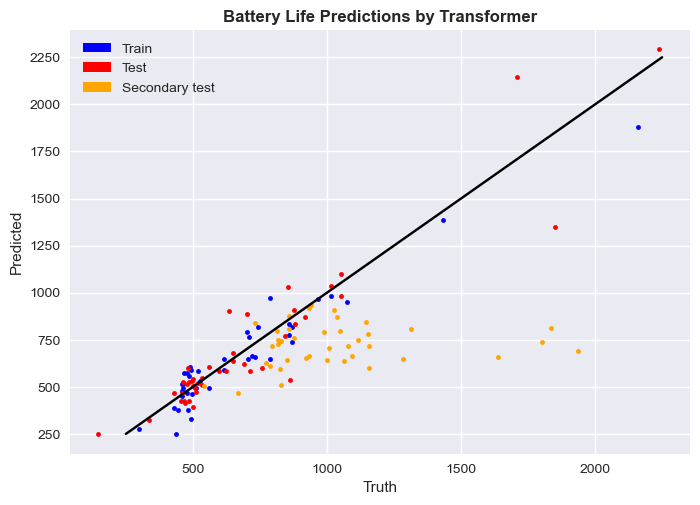

In [133]:
fig,ax = plt.subplots()
colors = ["blue","red","orange"]
for i,dataset in enumerate([train,test,stest]):
    predicted =[]
    labels = []
    for cell in dataset:
        input, label = cell
        predicted.append(10**model(input[None,:].to(device)).detach().numpy()[0,0])
        labels.append(10**label)
    print(np.sqrt(np.mean(np.power(np.array(predicted)-np.array(labels),2))))

    ax.plot(labels, predicted, ".",color=colors[i])
    ax.set_xlabel("Truth")
    ax.set_ylabel("Predicted")

ax.plot(np.linspace(250,2250),np.linspace(250,2250),color="black")
ax.set_title("Battery Life Predictions by Transformer",fontweight="semibold")

legend_elements = [Patch(facecolor='blue', label='Train'),
                   Patch(facecolor='red', label='Test'),
                   Patch(facecolor='orange', label='Secondary test')]
ax.legend(handles=legend_elements)
#plt.savefig("../images/transformer_output.png",dpi=300)